In [1]:


# Native libraries
import os
import math
# Essential Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Preprocessing
from sklearn.preprocessing import MinMaxScaler
# Algorithms
from minisom import MiniSom
import numpy.random as rd

import seaborn as sns

##MARCHENT PAS CAR NUMPY 1.20.3 MAIS PAS GRAVE POUR SOM
# from tslearn.barycenters import dtw_barycenter_averaging
# from tslearn.clustering import TimeSeriesKMeans
# from sklearn.cluster import KMeans

from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix



In [2]:
#fonctions et variables utiles

def read_text_file(file_path):
    with open(file_path, encoding='ISO-8859-1') as f:
        lines = f.readlines()
        return lines
        
def read_number_line(some_line):
    return [float(s) for s in some_line.split()]

# my_dpi = np.sqrt(1920**2 + 1080**2)/17.3 #dpi de l'écran
# tnorm = 60. #normalisation du temps
# vnorm = 1.05 #normalisation de la vitesse

In [3]:
##dossiers où récupérer les données

#training
folder = "C:/Users/victo/stage_navier_jupyter/data_eurotunnel/Data/training/"
pk_folder = "1775_20190128/" #le PK qu'on va traiter

done = ["1775_20190128/", "1780_20190128/", "1785_20190128/", "1795_20190128/", "1800_20190128/", "1805_20190128/",
        "1810_20190128/", "1815_20190128/", "1820_20190128/", "1825_20190128/", "1830_20190128/", "1835_20190128/",
        "1840_20190128/", "3020_20190218/", "3025_20190218/", "3030_20190218/", "3035_20190218/", "3040_20190218/",
        "3045_20190218/", "3050_20190218/", "3055_20190218/", "3060_20190218/", "3065_20190218/", "3070_20190218/",
        "3075_20190218/", "3080_20190218/", "4230_20190225/", "4235_20190225/", "4240_20190225/", "4255_20190225/",
        "4260_20190225/"]
failed = ["1790_20190128/", "3015_20190218"]

# #validation
# folder = "C:/Users/victo/stage_navier_jupyter/data_eurotunnel/Data/validation/"
# pk_folder = "4250_20190225/" #le PK qu'on va traiter

done_val = ["4245_20190225/", "4250_20190225/"]

os.chdir(folder)



In [4]:
# path = folder + pk_folder #pour accéder aux fichiers .blochet du PK pk_folder

mySeries = [] #series pandas
namesofMySeries = [] #nom correspondant a chaque blochet

# os.chdir(path) #current directory: C:/Users/victo/stage_navier_jupyter/data_eurotunnel/Data/training/1775-20190128/

def read_text_file(file_path):
    with open(file_path, encoding='ISO-8859-1') as f:
        lines = f.readlines()
        return lines
    
y_true = []

for pk_folder_loop in os.listdir(folder):
    if (pk_folder_loop + "/") in done:
        path = folder + pk_folder_loop
        for file in os.listdir(path):
            if file.endswith(".blochet"):
                file_path = f"{path}/{file}"
                lines = read_text_file(file_path)
                
                y_true.append(int(lines[-1][-1]))

                times = []
                speeds = []
                freqs = []
                frfs_real = []
                frfs_imag = []

                lines_to_read = lines[15:len(lines)-1] #valeurs commencent ligne 16 et saut de ligne à la fin
                
                for i in range(len(lines_to_read)):
                    read_line = read_number_line(lines_to_read[i])
                    times.append(read_line[0])
                    speeds.append(read_line[1])
                    freqs.append(read_line[2])
                    frfs_real.append(read_line[3])
                    frfs_imag.append(read_line[4])

                dict = {"Temps":times, "Vitesses":speeds, "Fréquences":freqs, "FRF réel":frfs_real, "FRF imag":frfs_imag}
                df = pd.DataFrame(dict)

                df = df.loc[:, ["Temps", "Vitesses"]]
                df.set_index("Temps", inplace=True)

                mySeries.append(df)
                namesofMySeries.append(pk_folder_loop + "_" + file[:-8])

In [5]:
len(mySeries)

4850

In [6]:
mySeries[42]

,Vitesses
Temps,
0.000000,0.001956
0.097656,0.002443
0.195312,0.001975
0.292969,0.003927
0.390625,0.002536
...,...
59.472660,-0.000771
59.570310,0.000244
59.667970,0.000449


In [7]:
y_true_values = {x for x in y_true}
print("Valeurs inscrites: " + str(y_true_values) + "\n" + 
      "Bonne longueur de liste: " + str(len(mySeries)==len(y_true)) + "\n" +
      "Pourcentage de blochets inexploitables: " + str(round(100*(1 - np.sum(y_true)/len(y_true)), 3)) + "%" + "\n")

#valeurs en float64

Valeurs inscrites: {0, 1}
Bonne longueur de liste: True
Pourcentage de blochets inexploitables: 18.186%



Visualisation (ne pas décommenter, ça affiche tous les blochets donc c'est très long)

In [8]:
# fig, axs = plt.subplots(485,10,figsize=(50,500))
# fig.suptitle('Series')
# for i in range(485):
#     for j in range(10):
#         if i*10+j+1>len(mySeries): # pass the others that we can't fill
#             continue
#         axs[i, j].plot(mySeries[i*10+j].values)
#         axs[i, j].set_title(namesofMySeries[i*10+j])
# plt.show()

Check si toutes les séries ont bien la même longueur:

In [9]:
series_lengths = {len(series) for series in mySeries}
print(series_lengths)

{614}


C'est le cas, pas besoin de correction on passe direct à la normalisation.

In [10]:
for i in range(len(mySeries)):
    scaler = MinMaxScaler()
    mySeries[i] = MinMaxScaler().fit_transform(mySeries[i])
    mySeries[i]= mySeries[i].reshape(len(mySeries[i]))

In [11]:
print("max: "+str(max(mySeries[0]))+"\tmin: "+str(min(mySeries[0])))
print(mySeries[0][-5:])

max: 1.0	min: 0.0
[0.40812886 0.40739371 0.40760733 0.40815812 0.40736352]


On a tout normalisé, on peut donc entraîner MiniSom sur nos données. On va faire varier le nombre de clusters entre 2 et 100, puis run chaque simulation 100 fois pour un nombre de clusters données afin d'avoir une moyenne.

In [12]:
fpr_rates = []

som_y = 4

for som_x in range(1, 25):

    nb_clusters = som_x*som_y
    
    fpr = []
    
    for counter in range(50):
        som = MiniSom(som_x, som_y,len(mySeries[0]), sigma=0.3, learning_rate = 0.1)

        som.random_weights_init(mySeries)
        som.train(mySeries, 5000)
#         print(som.quantization_error(mySeries)) #print(type(win_map[(4, 2)]))

        win_map = som.win_map(mySeries)

        #------------------------------------------------------------------------------------------------------------
        xpl_clusters = []
        nxpl_clusters = []

        nb_clusters = som_x*som_y #vaut 81
        cluster_exploitability = [0]*nb_clusters
        cluster_results = []
        for count in range(nb_clusters):
            cluster_results.append([])    

        #------------------------------------------------------------------------------------------------------------
        y_pred = []

        for i in range(len(mySeries)):
            (x, y) = som.winner(mySeries[i])
            cluster_results[x*som_y+y].append(y_true[i])

        for j in range(nb_clusters):
            if len(cluster_results[j]) > 0:
                avg = np.sum(cluster_results[j])/len(cluster_results[j])
                cluster_exploitability[j] = round(avg)

        for sample in mySeries:
            (x, y) = som.winner(sample)
            y_pred.append(cluster_exploitability[x*som_y + y])

        #------------------------------------------------------------------------------------------------------------
        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = cm.ravel()

        fpr.append(fp/(fp+tn))
    
    fpr_avg = np.sum(fpr)/len(fpr)
    print("FPR moyen pour " + str(nb_clusters) + " clusters: " + str(fpr_avg))
    fpr_rates.append(fpr_avg)

FPR moyen pour 4 clusters: 0.5736961451247167
FPR moyen pour 8 clusters: 0.6547392290249434
FPR moyen pour 12 clusters: 0.4023809523809524
FPR moyen pour 16 clusters: 0.34199546485260773
FPR moyen pour 20 clusters: 0.3315873015873016
FPR moyen pour 24 clusters: 0.2761224489795918
FPR moyen pour 28 clusters: 0.2891609977324263
FPR moyen pour 32 clusters: 0.25630385487528345
FPR moyen pour 36 clusters: 0.24276643990929703
FPR moyen pour 40 clusters: 0.21120181405895694
FPR moyen pour 44 clusters: 0.20204081632653062
FPR moyen pour 48 clusters: 0.20684807256235824
FPR moyen pour 52 clusters: 0.19727891156462588
FPR moyen pour 56 clusters: 0.1852607709750567
FPR moyen pour 60 clusters: 0.18217687074829933
FPR moyen pour 64 clusters: 0.18569160997732428
FPR moyen pour 68 clusters: 0.18024943310657593
FPR moyen pour 72 clusters: 0.1719274376417234
FPR moyen pour 76 clusters: 0.17941043083900227
FPR moyen pour 80 clusters: 0.16979591836734695
FPR moyen pour 84 clusters: 0.17433106575963717
FP

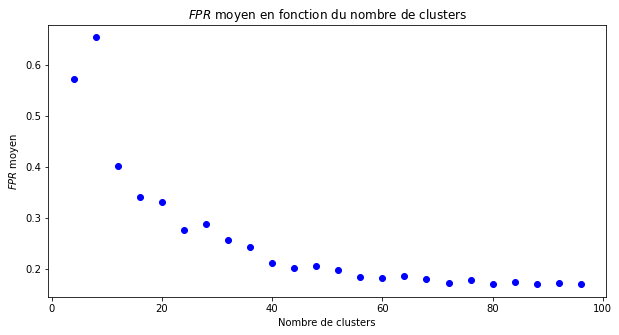

In [15]:
fig = plt.figure(figsize=(10, 5))
nb_clusters_list = [x*4 for x in range(1, 25)]
plt.plot(nb_clusters_list, fpr_rates, 'bo')
plt.xlabel("Nombre de clusters")
plt.ylabel("$FPR$ moyen")
plt.title("$FPR$ moyen en fonction du nombre de clusters")
plt.show()